In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [15]:

# Load the CSV file
train_df = pd.read_csv('train.csv')

# Display the first few rows of the dataframe
train_df.head()

,UID,AgriculturalPostalZone,AgricultureZoningCode,CropFieldConfiguration,CropSpeciesVariety,CultivatedAndWildArea,CultivatedAreaSqft1,DistrictId,FarmClassification,FarmEquipmentArea,...,TotalTaxAssessed,TotalValue,TownId,TypeOfIrrigationSystem,UndergroundStorageSqft,ValuationYear,WaterAccessPoints,WaterAccessPointsCalc,WaterReservoirCount,Target
0,12998,291674,0.0,NaN,3.0,NaN,1136.0,1.0,NaN,NaN,...,8636.716,456255.6,118.0,NaN,NaN,2018.0,2.0,2.0,NaN,high
1,20860,164397,28.0,NaN,4.0,NaN,2083.0,1.0,NaN,NaN,...,18464.292,996887.6,24.0,1.0,NaN,2018.0,3.0,3.0,1.0,medium
2,75725,616532,0.0,NaN,2.0,NaN,922.0,1.0,NaN,NaN,...,15594.568,1043780.0,9.0,1.0,NaN,2018.0,1.0,1.0,NaN,medium
3,106521,942111,43.0,NaN,7.0,NaN,NaN,1.0,NaN,NaN,...,8494.618,435734.8,114.0,NaN,NaN,2020.0,3.0,3.0,NaN,low
4,99467,475557,38.0,NaN,3.0,NaN,2225.0,3.0,NaN,0.0,...,13517.284,885400.0,6.0,NaN,NaN,2020.0,4.0,4.0,NaN,medium


In [16]:


# Define the preprocessing steps for numerical and categorical features
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_df.select_dtypes(include=['object']).columns

# Create a preprocessing pipeline for numerical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Convert everything to float
# Map the categorical 'Target' column to numerical values
target_mapping = {'low': 0, 'medium': 1, 'high': 2}
train_df['Target'] = train_df['Target'].map(target_mapping)

# Create a preprocessing pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the numerical and categorical pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Fit and transform the data
train_df_preprocessed = preprocessor.fit_transform(train_df)


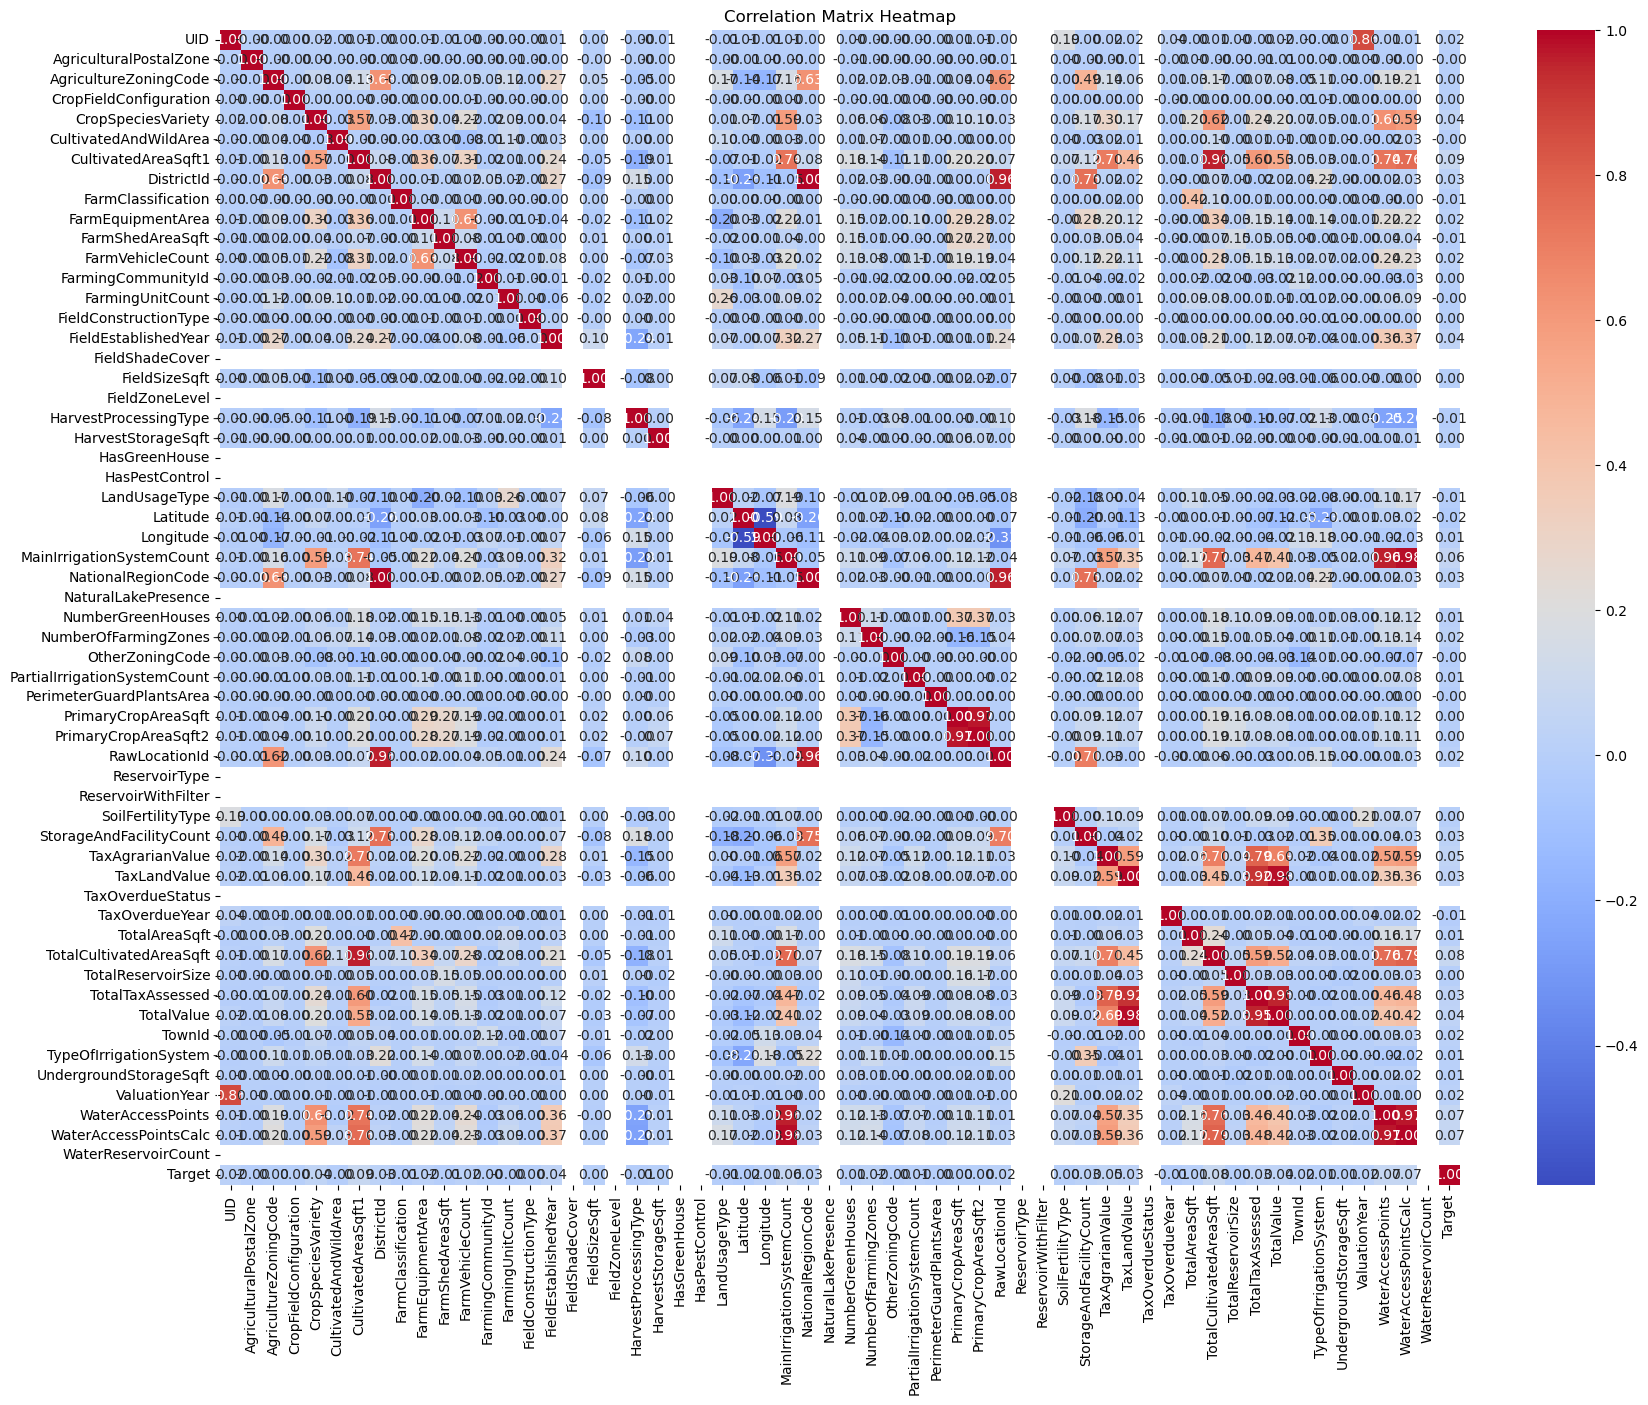

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the transformed data back to a DataFrame
train_df_transformed = pd.DataFrame(train_df_preprocessed, columns=numerical_features.tolist() + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)))
# Add the target column back to the transformed DataFrame
train_df_transformed['Target'] = train_df['Target']
train_df_transformed.drop(columns=["Target_0", "Target_1", "Target_2"], inplace=True)
# Calculate the correlation matrix
correlation_matrix = train_df_transformed.corr()

# Create a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

        Target
0            2
1            1
2            1
3            0
4            1
...        ...
112564       1
112565       1
112566       2
112567       1
112568       0

[112569 rows x 1 columns]


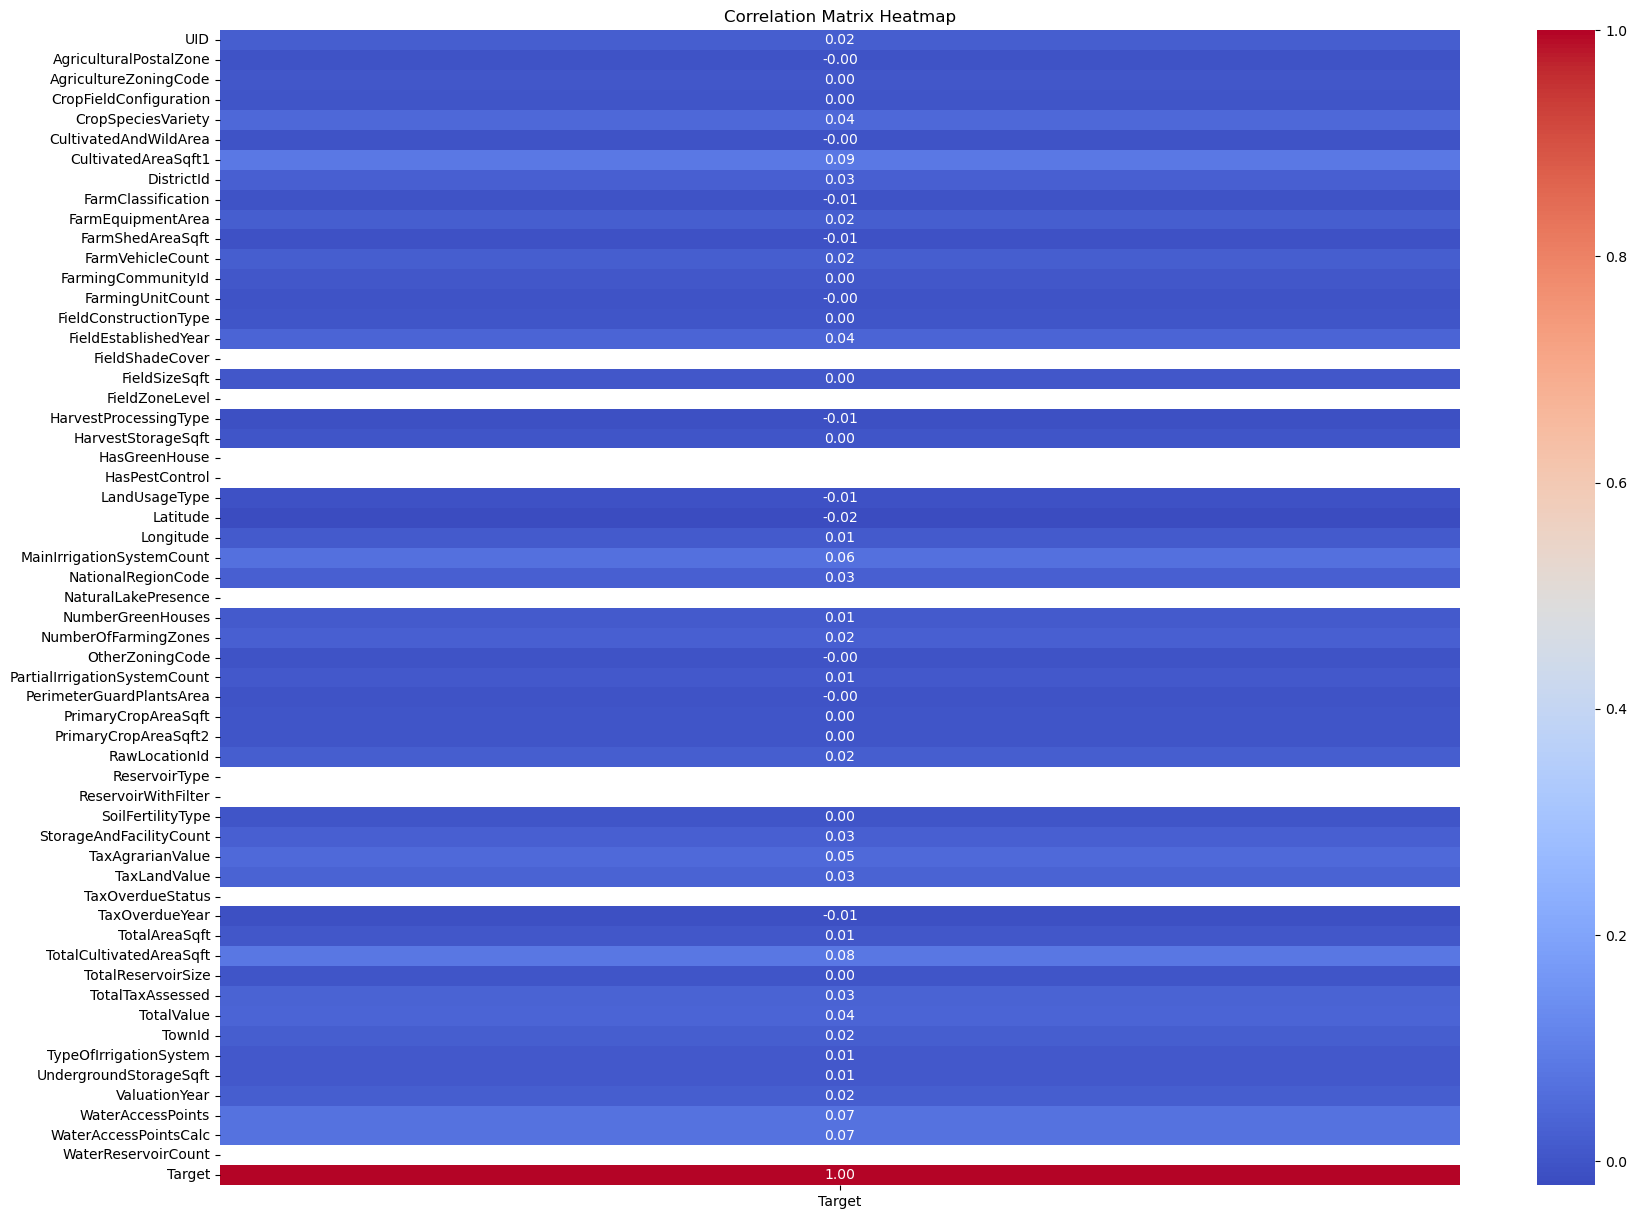

In [18]:
print(train_df_transformed[["Target"]])
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix[["Target"]], annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the data into features and target

X = train_df_transformed.drop(columns=['Target'])

y = train_df_transformed['Target']
# Drop irrelevant columns
X = X.dropna()
irrelevant_columns = [
    'UID', 'FieldShadeCover', 'PerimeterGuardPlantsArea', 'PrimaryCropAreaSqft2', 
    'CultivatedAndWildArea', 'TotalAreaSqft', 'NationalRegionCode', 'NumberGreenHouses', 
    'FarmVehicleCount', 'Latitude', 'Longitude', 'FieldSizeSqft', 'WaterReservoirCount', 
    'TotalReservoirSize', 'ReservoirType', 'ReservoirWithFilter', 'NaturalLakePresence', 
    'RawLocationId', 'TownId', 'DistrictId', 'FarmingCommunityId', 'AgriculturalPostalZone', 
    'StorageAndFacilityCount', 'PartialIrrigationSystemCount', 'FarmingUnitCount', 
    'FarmShedAreaSqft', 'HarvestStorageSqft', 'FieldEstablishedYear', 'NumberOfFarmingZones', 
    'HasGreenHouse', 'TaxAgrarianValue', 'TaxLandValue', 'TotalValue', 'TotalTaxAssessed', 
    'ValuationYear', 'TaxOverdueStatus', 'TaxOverdueYear', 'OtherZoningCode'
]

X = X.drop(columns=irrelevant_columns)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the classifier
clf = RandomForestClassifier(max_depth=100,n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.5113262858665719
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.18      0.21      4462
           1       0.63      0.73      0.67     13526
           2       0.25      0.19      0.22      4526

    accuracy                           0.51     22514
   macro avg       0.37      0.37      0.36     22514
weighted avg       0.47      0.51      0.49     22514



In [20]:

# Define the inverse target mapping
inverse_target_mapping = {v: k for k, v in target_mapping.items()}

test_df = pd.read_csv('test.csv')

# Add "Target" column with all values set to 1
test_df['Target'] = 1
# Preprocess the test data
test_df_preprocessed = preprocessor.transform(test_df)

# Convert the transformed data back to a DataFrame
test_df_transformed = pd.DataFrame(test_df_preprocessed, columns=numerical_features.tolist() + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)))
test_df_transformed = test_df_transformed.drop(columns=['Target_0', 'Target_1', 'Target_2'])
irrelevant_columns = [
    'UID', 'FieldShadeCover', 'PerimeterGuardPlantsArea', 'PrimaryCropAreaSqft2', 
    'CultivatedAndWildArea', 'TotalAreaSqft', 'NationalRegionCode', 'NumberGreenHouses', 
    'FarmVehicleCount', 'Latitude', 'Longitude', 'FieldSizeSqft', 'WaterReservoirCount', 
    'TotalReservoirSize', 'ReservoirType', 'ReservoirWithFilter', 'NaturalLakePresence', 
    'RawLocationId', 'TownId', 'DistrictId', 'FarmingCommunityId', 'AgriculturalPostalZone', 
    'StorageAndFacilityCount', 'PartialIrrigationSystemCount', 'FarmingUnitCount', 
    'FarmShedAreaSqft', 'HarvestStorageSqft', 'FieldEstablishedYear', 'NumberOfFarmingZones', 
    'HasGreenHouse', 'TaxAgrarianValue', 'TaxLandValue', 'TotalValue', 'TotalTaxAssessed', 
    'ValuationYear', 'TaxOverdueStatus', 'TaxOverdueYear', 'OtherZoningCode'
]
test_df_transformed= test_df_transformed.drop(columns=irrelevant_columns)
# Make predictions on the test data
test_predictions = clf.predict(test_df_transformed)

# Create a results DataFrame
results = pd.DataFrame()
results["UID"] = test_df["UID"]
results['Target'] = test_predictions
results['Target'] = results['Target'].map(inverse_target_mapping)

# Save the results to a new CSV file
results.to_csv('test_results.csv', index=False)

print("Predictions saved to test_results.csv")

Predictions saved to test_results.csv
